# Demonstrating alignment transforms between Connectors, including dihedral angle setting
N.B.: the outputs of this notebook are to SD files containing the "trajectory" of each alignment;  
these can be visualized in one's molecule viewing software of choice (e.g. PyMol, VMD, even VSCode with the ProteinViewer extension enabled, etc.)

In [1]:
from pathlib import Path

alignment_dir = Path('alignments')
alignment_dir.mkdir(exist_ok=True)

## Helper functions

In [2]:
import numpy as np
from scipy.spatial.transform import Slerp, Rotation, RigidTransform


def interpolate_rigid_transformation(
    transformation : RigidTransform,
    n_steps_rotate : int = 50,
    n_steps_translate : int = 50,
) -> tuple[tuple[RigidTransform], tuple[RigidTransform]]:
    '''
    Generates interpolated keyframes for a rigid transformation, each of which represents a
    "partial" transformation somewhere between the identity and the provided transformation
    
    Decomposes RigidTransform into rotation and translation components, and returns separately
    the sequences of interpolated rotation and translation (+ net rotation) keyframes
    '''
    unity_endpoints = (0.0, 1.0)
    
    # initial rotation
    net_rotation = transformation.rotation
    rotation_keyframes = tuple(
        RigidTransform.from_rotation(partial_rot)
        for partial_rot in Slerp(
            unity_endpoints,
            Rotation.concatenate([Rotation.identity(), net_rotation])
        )(np.linspace(*unity_endpoints, num=n_steps_rotate))
    )
    
    # Translation (following net rotation)
    net_translation = transformation.translation
    translation_keyframes = tuple(
        RigidTransform.from_components(
            translation=partial_translation,
            rotation=net_rotation
        )
        for partial_translation in np.outer(
            np.linspace(*unity_endpoints, num=n_steps_translate),
            net_translation
        )
    )
    return rotation_keyframes, translation_keyframes

In [3]:
from rdkit.Chem import Mol, SDWriter, CombineMols

def label_atoms_for_ctab(mol : Mol) -> None:
    '''
    Labels each atom in the provided RDKit Mol with a unique alias for use in CTAB exports
    Helps disentangle which atom belongs to which molecule when multiple molecules are combined
    '''
    for atom in mol.GetAtoms():
        atom.SetProp('molFileAlias', f'{mol.GetProp("_Name")}_A{atom.GetIdx()}')

## Define example molecule fragments
The linker ("*") sites represent off-molecule neighbor points which can be attached to one another  

The collection of a linker, the "real" body it's anchored to (called the "anchor", to no one's surprise), and the bond between them  
are collectively referred to as a "Connector" which is a fundamental component of the MuPT hierarchical molecular representation  

[18:24:14] UFFTYPER: Unrecognized atom type: *_ (8)
[18:24:14] UFFTYPER: Unrecognized atom type: *_ (11)
[18:24:14] UFFTYPER: Unrecognized atom type: *_ (0)


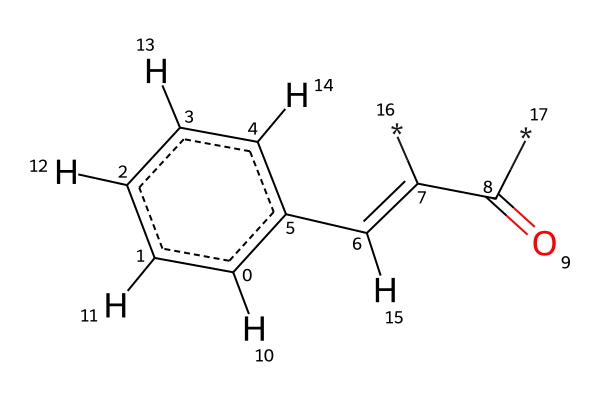

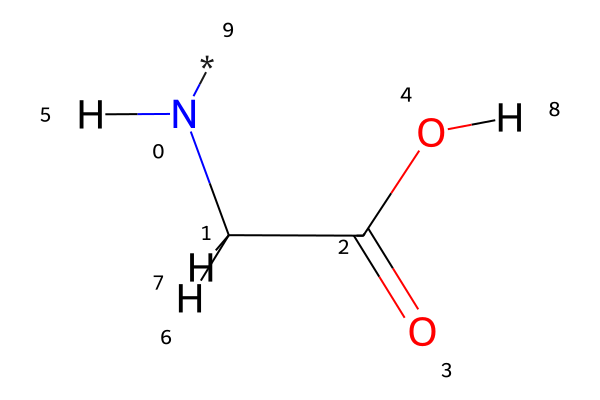

In [ ]:
from rdkit.Chem.rdchem import Mol
from mupt.interfaces.rdkit import primitive_to_rdkit
from mupt.interfaces.smiles import primitive_from_smiles


prim1 = primitive_from_smiles(
    'c1ccccc1C=C(-[1*])C(=O)[2*]',
    label='cinnamic_acid',
    embed_positions=True,
    ensure_explicit_Hs=True,
)
prim2 = primitive_from_smiles(
    '[3*][NH]CC(=O)O',
    label='glycine',
    embed_positions=True,
    ensure_explicit_Hs=True,
)

for prim in (prim1, prim2):
    display(primitive_to_rdkit(prim))

## Alignment mechanism 1: Rigid alignment
In which the first Connector remains fixed, while the second is rigidly moved to have its attachment points antialigned with the first

In [6]:
n_steps_rotate_rigid : int = 50
n_steps_translate_rigid : int = 50
n_steps_dihedral : int = 100

In [ ]:
# calculate and apply transform
## copy molecule fragments to avoid modifying conformers for operations following rigid alignment
prim1_rigid = prim1.copy()
prim2_rigid = prim2.copy()

conn_handle1 = list(prim1_rigid.connectors.keys())[1]
conn_handle2 = list(prim2_rigid.connectors.keys())[0]
## need to reach down onto Connector counterpart on children to get changes to show in all-atom export
conn1 = prim1_rigid.fetch_connector_on_child(prim1_rigid.external_connectors[conn_handle1])
conn2 = prim2_rigid.fetch_connector_on_child(prim2_rigid.external_connectors[conn_handle2])

conn2.set_bond_length(conn1.bond_length) # ensure the Connector on the molecule being moved has a compatible bond length

mol1_rigid = primitive_to_rdkit(prim1_rigid)
mol2_rigid = primitive_to_rdkit(prim2_rigid)

In [8]:
rigid_antialignment : RigidTransform = conn2.rigid_antialignment_to(conn1, tare_dihedrals=True)
turns, shifts = interpolate_rigid_transformation(
    rigid_antialignment,
    n_steps_rotate=n_steps_rotate_rigid,
    n_steps_translate=n_steps_translate_rigid,
)

# write series of intermediate transforms to SDF
with SDWriter(alignment_dir / 'alignment_rigid.sdf') as writer:
    ## interpolate initial transform to dihedral of 0 radians
    for transform in (*turns, *shifts):
        prim2_rigid.rigidly_transform(transform)
        combomol = CombineMols(mol1_rigid, primitive_to_rdkit(prim2_rigid))
        writer.write(combomol, confId=0)
        prim2_rigid.rigidly_transform(transform.inv()) # reset to avoid accumulation errors

    ## apply net rigid alignment transformation to avoid it disappearing in the animation
    prim2_rigid.rigidly_transform(rigid_antialignment)

    ## sweep through a full turn of dihedral angles
    for angle_rad in np.linspace(0, 2*np.pi, num=n_steps_dihedral):
        dihedral_alignment = conn2.dihedral_assignment_transform(conn1, dihedral_angle_rad=angle_rad)
        prim2_rigid.rigidly_transform(dihedral_alignment)
        combomol = CombineMols(mol1_rigid, primitive_to_rdkit(prim2_rigid))
        writer.write(combomol, confId=0)
        prim2_rigid.rigidly_transform(dihedral_alignment.inv()) # reset to avoid accumulation errors
    
print(f'Connectors ended aligned: {conn1.are_antialigned(conn2)}')

Connectors ended aligned: True


## Alignment mechanism 2: Ballistic alignment
In which the anchor sites of both Connectors remain fixed, and linker linkers are "aimed" atom the others' anchor site

In [9]:
n_steps_rotate_ballistic : int = 50
n_steps_translate_ballistic : int = 50
n_steps_stretch : int = 50

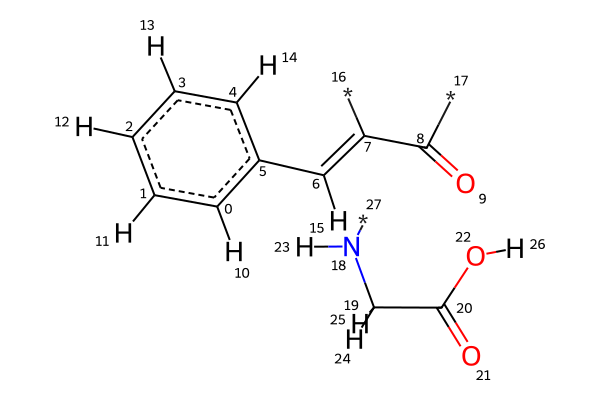

In [10]:
# define molecular primitives being ballistically aligned
shift = RigidTransform.from_translation(np.array([3.0, -3.0, 0.0])) # move second molecule so they don't overlap
prim1_ballis = prim1.copy()
prim2_ballis = prim2.rigidly_transformed(shift)

# select pair of Connectors to align
conn_handle1 = list(prim1_ballis.connectors.keys())[1]
conn_handle2 = list(prim2_ballis.connectors.keys())[0]
## need to reach down onto Connector counterpart on children to get changes to show in all-atom export
conn1 = prim1_ballis.fetch_connector_on_child(prim1_ballis.external_connectors[conn_handle1])
conn2 = prim2_ballis.fetch_connector_on_child(prim2_ballis.external_connectors[conn_handle2])

display(CombineMols(
    primitive_to_rdkit(prim1_ballis),
    primitive_to_rdkit(prim2_ballis),
))

In [ ]:
# define keyframes for animated alignment
turns_ballis, shifts_ballis = interpolate_rigid_transformation(
    conn2.ballistic_antialignment_to(conn1),
    n_steps_rotate=n_steps_rotate_ballistic,
    n_steps_translate=n_steps_translate_ballistic,
)

mol1_ballis = primitive_to_rdkit(prim1_ballis)
with SDWriter(alignment_dir / 'alignment_ballistic.sdf') as writer:
    ## show ballistic "aiming" at target connector
    for transform in (*turns_ballis, *shifts_ballis):
        conn2.rigidly_transform(transform)
        combomol = CombineMols(mol1_ballis, primitive_to_rdkit(prim2_ballis))
        writer.write(combomol, confId=0)
        conn2.rigidly_transform(transform.inv()) # reset to avoid accumulation errors

    ## apply net aiming transformation to avoid it disappearing in the animation
    conn2.antialign_ballistically_to(conn1)
        
    ## show stretching of Connector bond "shooting" at target Connector
    bond_length_range = np.linspace(
        conn2.bond_length,
        np.linalg.norm(conn1.anchor.position - conn2.anchor.position),
        num=n_steps_stretch,
    )
    for bond_length in bond_length_range:
        conn2.set_bond_length(bond_length)
        combomol = CombineMols(mol1_ballis, primitive_to_rdkit(prim2_ballis))
        writer.write(combomol, confId=0)